In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, auc, roc_curve, classification_report
from sklearn.preprocessing import LabelEncoder, Imputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence, partial_dependence

In [2]:
data = pd.read_csv('Fraud_data/Fraud_Data.csv', parse_dates = ['signup_time', 'purchase_time'])
data.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
adr2con = pd.read_csv('Fraud_data/IpAddress_to_Country.csv')
adr2con.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [4]:
#Add County to the dataset
country =[]
for i in range(len(data)):
    ip_address = data.loc[i,'ip_address']
    tmp = adr2con[(adr2con['lower_bound_ip_address'] <= ip_address) &
                  (adr2con['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        country.append(tmp['country'].values[0])
    else:
        country.append('NA')
data['country'] = country
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


* Time difference btw signup and purchase. --> time_diff
* Certain users with same device? --> device_num 
* Certain users with same ip address? -->ip_num 
* Day of week sign up -->signup_day
* Week of year sign up --> signup_week
* Day of week purchase -->purchase_day
* Week of year purchase --> purchase_week

In [5]:
#time_diff
time_diff = data['purchase_time'] - data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['time_diff'] = time_diff

In [6]:
#device_num
device_num = data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns = {'user_id': 'device_num'})
data = data.merge(device_num, how = 'left', on = 'device_id')
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1


In [7]:
#ip_num
ip_num = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns = {'user_id': 'ip_num'})
data = data.merge(ip_num, how = 'left', on = 'ip_address')

In [8]:
#signup day of week, week of year
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

#purchase day of week, week of year
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


In [9]:
#Features used in the model
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
data = data[columns]
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


In [10]:
#Categorical Feature Encoding: source,browser,sex,country
lb = LabelEncoder()
data['source_lb'] = lb.fit_transform(data['source'])
data['browser_lb'] = lb.fit_transform(data['browser'])
data['sex_lb'] = lb.fit_transform(data['sex'])
data['country_lb'] = lb.fit_transform(data['country'])
data[['source_lb', 'source']].head(5)


,source_lb,source
0,2,SEO
1,0,Ads
2,2,SEO
3,2,SEO
4,0,Ads


In [11]:
lb_columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source_lb', 'browser_lb', 'sex_lb', 'age', 'country_lb', 'time_diff', 'device_num', 'ip_num', 'class']
data_lb = data[lb_columns]
data_lb.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source_lb,browser_lb,sex_lb,age,country_lb,time_diff,device_num,ip_num,class
0,1,9,5,16,34,2,0,1,39,84,13882,1,1,0
1,6,23,0,24,16,0,0,0,53,172,17944,1,1,0
2,3,1,3,1,15,2,3,1,53,172,1,12,12,1
3,1,18,0,19,44,2,4,1,41,115,60085,1,1,0
4,1,30,2,37,39,0,4,1,45,172,41461,1,1,0


In [12]:
#Split 70% training set
y = data_lb['class']
X_train, X_test, y_train, y_test = train_test_split(data_lb.iloc[:,:-1], y, random_state = 42, test_size = 0.3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(105778, 13) (105778,)
(45334, 13) (45334,)


In [38]:
#Random Forest Model
rf = RandomForestClassifier(n_estimators = 60, oob_score = True, random_state = 42, max_depth = 15, min_samples_split = 3, 
                            min_samples_leaf = 35, class_weight = 'balanced', )
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=35,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=None, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [39]:
y_pred = rf.predict(X_train)
y_test_pre = rf.predict(X_test)
print ('AUC Score(Train):')
print(roc_auc_score(y_train, y_pred))
print('AUC Score(Test):')
print(roc_auc_score(y_test, y_test_pre))

AUC Score(Train):
0.8247196006812191
AUC Score(Test):
0.8301511711816968


In [15]:
#Adjust Model Params for better fit 
#n-estimator
param_test1 = {'n_estimators': range(10,71,10)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(oob_score = True, min_samples_split= 5, max_depth=10, random_state=42, min_samples_leaf = 40, class_weight = 'balanced'), 
                        param_grid = param_test1, scoring = 'roc_auc',cv=5)
gsearch1.fit(X_train,y_train)


C:\Users\danyu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\danyu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\danyu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\danyu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OO

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=40,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=True,
            random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(10, 71, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [16]:
res_df = pd.DataFrame(gsearch1.cv_results_)[['mean_train_score','std_train_score', 'params']]
print('Train param of n_estimators:')
res_df, gsearch1.best_params_, gsearch1.best_score_

Train param of n_estimators:


(   mean_train_score  std_train_score                params
 0          0.906696         0.002388  {'n_estimators': 10}
 1          0.920085         0.002345  {'n_estimators': 20}
 2          0.927736         0.002796  {'n_estimators': 30}
 3          0.933454         0.001615  {'n_estimators': 40}
 4          0.936170         0.001356  {'n_estimators': 50}
 5          0.938155         0.001653  {'n_estimators': 60}
 6          0.940006         0.001954  {'n_estimators': 70},
 {'n_estimators': 60},
 0.8407547275837657)

In [17]:
#max_depth & min_samples_split
param_test2 = {'max_depth': range(5,31,5), 'min_samples_split': range(3,9,2)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 40,oob_score = True, random_state = 42, min_samples_leaf = 40, class_weight = 'balanced'),
                       param_grid = param_test2, scoring = 'roc_auc', cv = 5)
gsearch2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=40,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=None, oob_score=True, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(5, 31, 5), 'min_samples_split': range(3, 9, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [18]:
res_df2 = pd.DataFrame(gsearch2.cv_results_)[['mean_train_score','std_train_score', 'params']]
print('Train param of max_depth & min_samples_split:')
res_df2, gsearch2.best_params_, gsearch2.best_score_

Train param of max_depth & min_samples_split:


(    mean_train_score  std_train_score  \
 0           0.865621         0.001507   
 1           0.865621         0.001507   
 2           0.865621         0.001507   
 3           0.933454         0.001615   
 4           0.933454         0.001615   
 5           0.933454         0.001615   
 6           0.969751         0.000832   
 7           0.969751         0.000832   
 8           0.969751         0.000832   
 9           0.975545         0.000446   
 10          0.975545         0.000446   
 11          0.975545         0.000446   
 12          0.976299         0.000235   
 13          0.976299         0.000235   
 14          0.976299         0.000235   
 15          0.976435         0.000287   
 16          0.976435         0.000287   
 17          0.976435         0.000287   
 
                                        params  
 0    {'max_depth': 5, 'min_samples_split': 3}  
 1    {'max_depth': 5, 'min_samples_split': 5}  
 2    {'max_depth': 5, 'min_samples_split': 7}  
 3  

In [26]:
#min_samples_leaf
param_test3 = {'min_samples_leaf': range(20, 51, 5)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 40,oob_score = True, random_state = 42, min_samples_split = 3, max_depth = 15,class_weight = 'balanced'),
                       param_grid = param_test3, scoring = 'roc_auc', cv = 5)
gsearch3.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=15, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=None, oob_score=True, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_leaf': range(20, 51, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [27]:
res_df3 = pd.DataFrame(gsearch3.cv_results_)[['mean_train_score','std_train_score', 'params']]
print('Train param of max_depth & min_samples_split:')
res_df3, gsearch3.best_params_, gsearch3.best_score_

Train param of max_depth & min_samples_split:


(   mean_train_score  std_train_score                    params
 0          0.976096         0.000489  {'min_samples_leaf': 20}
 1          0.974779         0.000384  {'min_samples_leaf': 25}
 2          0.973116         0.000274  {'min_samples_leaf': 30}
 3          0.971667         0.000321  {'min_samples_leaf': 35}
 4          0.969751         0.000832  {'min_samples_leaf': 40}
 5          0.968077         0.000487  {'min_samples_leaf': 45}
 6          0.966649         0.000531  {'min_samples_leaf': 50},
 {'min_samples_leaf': 35},
 0.8420717552136241)

In [40]:
features = list(X_train.columns)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
ipt = sorted(zip(features, importances), key = lambda x: x[1], reverse = True)
print('Feature Importance Ranking:')
for f,val in ipt:
    print('{0:10s} | {1:.5f}'.format(f, val))


Feature Importance Ranking:
device_num | 0.32670
time_diff  | 0.22941
purchase_week | 0.13489
signup_week | 0.13194
ip_num     | 0.08345
purchase_value | 0.02251
age        | 0.01852
country_lb | 0.01430
signup_day | 0.01084
purchase_day | 0.00992
browser_lb | 0.00749
source_lb  | 0.00643
sex_lb     | 0.00359


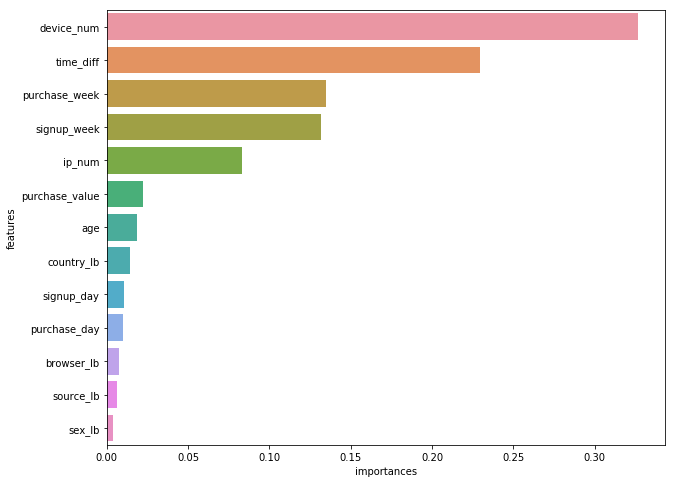

In [41]:
#plot feature importances
plt_ipt = pd.DataFrame(data = ipt, columns =['features', 'importances'])
fig, ax = plt.subplots(figsize = (10,8))
sns.barplot(x = 'importances', y = 'features', data = plt_ipt)
plt.show()


In [42]:
#Prediction
train_pre = rf.predict(X_train)
test_pre = rf.predict(X_test)

train_fpr, train_tpr, _ = roc_curve(y_train, train_pre)
test_fpr, test_tpr, _ = roc_curve(y_test, test_pre)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(train_fpr, train_tpr), 3)


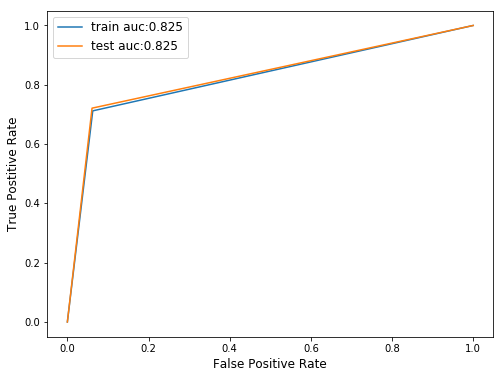

In [44]:
#plt
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(train_fpr, train_tpr, label = 'train auc:' + str(train_auc))
ax.plot(test_fpr, test_tpr, label = 'test auc:' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize = 12)
ax.set_ylabel('True Postitive Rate', fontsize = 12)
ax.legend(fontsize = 12)
plt.show()

C:\Users\danyu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


NameError: name 'my_model' is not defined